In [2]:
#imports
import os
from six.moves import urllib
import pandas as pd
import numpy as np 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [3]:
DOWNLOAD_ROOT = "http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening"
CREDIT_DATA_URL = DOWNLOAD_ROOT + "/crx.data"
CREDIT_DATA_PATH = "datasets/credit-screening"

In [4]:
# fetch data from its origin
def fetch_credit_crad_data(credit_data_url=CREDIT_DATA_URL, credit_path=CREDIT_DATA_PATH):
    if not os.path.isdir(credit_path):
        os.makedirs(credit_path)
    credit_data_path = os.path.join(credit_path, "crx.data")
    urllib.request.urlretrieve(credit_data_url, credit_data_path)

fetch_credit_crad_data()

In [5]:
def load_credit_card_data(credit_data_path=CREDIT_DATA_PATH):
    csv_path=os.path.join(credit_data_path, "crx.data")
    pd.set_option('display.max_columns', None)
    col_names = ["Gender","Age","Debt","Married","BankCustomer","EducationLevel","Ethnicity","YearsEmployed","PriorDefault","Employed","CreditScore", "DriversLicense", "Citizen", "ZipCode", "Income" , "ApprovalStatus"]
    return pd.read_csv(csv_path, header=None, names=col_names)

dataset = load_credit_card_data()
dataframe = dataset.copy()
dataset.head()

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,ApprovalStatus
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [6]:
#replace missing numeric values with mean
dataset = dataset.replace("?", np.nan).replace('+', 1).replace('-', 0)
dataset.fillna(dataset.mean(), inplace=True)
#replace missing object values with the most freequent value
for col in dataset:
    if dataset[col].dtypes == 'object':
        dataset = dataset.fillna(dataset[col].value_counts().index[0])

dataset.isna().sum()

Gender            0
Age               0
Debt              0
Married           0
BankCustomer      0
EducationLevel    0
Ethnicity         0
YearsEmployed     0
PriorDefault      0
Employed          0
CreditScore       0
DriversLicense    0
Citizen           0
ZipCode           0
Income            0
ApprovalStatus    0
dtype: int64

In [7]:
dataset['ApprovalStatus'].value_counts()

0    383
1    307
Name: ApprovalStatus, dtype: int64

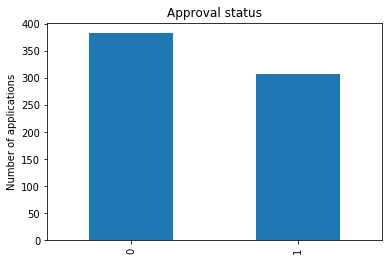

In [8]:
CountStatus = pd.value_counts(dataset['ApprovalStatus'].values, sort=False)
plt.ylabel('Number of applications')
plt.title('Approval status')
CountStatus.plot.bar()

In [9]:
dataset.dtypes

Gender             object
Age                object
Debt              float64
Married            object
BankCustomer       object
EducationLevel     object
Ethnicity          object
YearsEmployed     float64
PriorDefault       object
Employed           object
CreditScore         int64
DriversLicense     object
Citizen            object
ZipCode            object
Income              int64
ApprovalStatus      int64
dtype: object

In [10]:
#encode values for the algorithm
#ohe = preprocessing.OneHotEncoder()

le = preprocessing.LabelEncoder()

for col in dataset:
    if dataset[col].dtypes == 'object':
        dataset[col]=le.fit_transform(dataset[col])
dataset.dtypes

Gender              int64
Age                 int64
Debt              float64
Married             int64
BankCustomer        int64
EducationLevel      int64
Ethnicity           int64
YearsEmployed     float64
PriorDefault        int64
Employed            int64
CreditScore         int64
DriversLicense      int64
Citizen             int64
ZipCode             int64
Income              int64
ApprovalStatus      int64
dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125a7e358>,
      dtype=object)

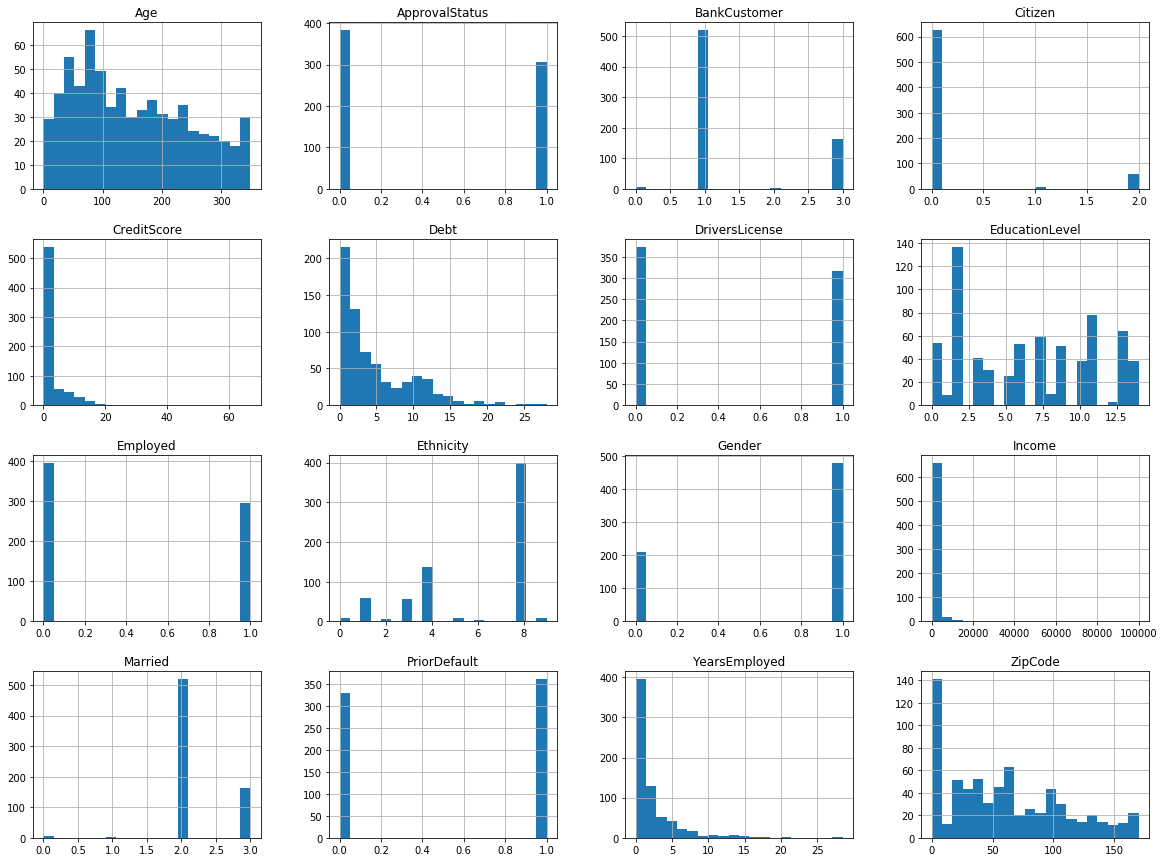

In [11]:
dataset.hist(bins=20, figsize=(20, 15))

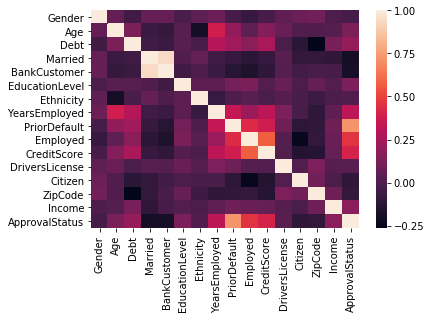

In [12]:
def make_corr_heatmap(data):
    corr = data.corr()
    sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

make_corr_heatmap(dataset)

In [13]:
dataset.corr()['ApprovalStatus'].sort_values()

Married          -0.191431
BankCustomer     -0.187520
Citizen          -0.100867
ZipCode          -0.094851
Gender           -0.028934
Ethnicity         0.000877
DriversLicense    0.031625
EducationLevel    0.130026
Age               0.133304
Income            0.175657
Debt              0.206294
YearsEmployed     0.322475
CreditScore       0.406410
Employed          0.458301
PriorDefault      0.720407
ApprovalStatus    1.000000
Name: ApprovalStatus, dtype: float64

In [14]:
#use MAD to check the spread of the observation from the mean. MAD > std because we have outliers like age, income
dataset.mad()

Gender               0.423440
Age                 82.546335
Debt                 3.941786
Married              0.370439
BankCustomer         0.727536
EducationLevel       3.875156
Ethnicity            2.395346
YearsEmployed        2.223883
PriorDefault         0.498925
Employed             0.489498
CreditScore          3.088116
DriversLicense       0.496467
Citizen              0.320311
ZipCode             40.415312
Income            1533.165402
ApprovalStatus       0.493934
dtype: float64

In [15]:
#drop columns with the lowest correlation, or columns that do not make sense
dataset = dataset.drop(['DriversLicense', 'ZipCode', 'Ethnicity', 'Gender'], axis=1)

In [16]:
#separate the features and labels
dataset = dataset.values
X,y = dataset[:,0:11] , dataset[:,11]

#split the dataset into train, validation and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [17]:
#rescale the training and testing sets
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.fit_transform(X_test)
rescaledX_val = scaler.fit_transform(X_val)

In [18]:
#instantiate the algorithms
rfc = RandomForestClassifier(random_state=42, n_estimators=100)
gnb = GaussianNB()
logreg = LogisticRegression(solver='liblinear')

In [19]:
#use cross validation with 5 folds on the training data, since we have low amount of data
#produce the AUC score for each of the algorithms
print("Random Forrest")
roc_rfc = cross_val_score(rfc, X_train, y_train, scoring='roc_auc', cv = 5).mean()
f1_rfc = cross_val_score(rfc, X_train, y_train, scoring='f1', cv = 5).mean()
precision_rfc = cross_val_score(rfc, X_train, y_train, scoring='precision', cv = 5).mean()
rec_rfc = cross_val_score(rfc, X_train, y_train, scoring='recall', cv = 5).mean()
acc_rfc = cross_val_score(rfc, X_train, y_train, scoring='accuracy', cv = 5).mean()
print("AUC: " , roc_rfc)
print("F1: " , f1_rfc)
print("Precission: " , precision_rfc)
print("Recall: " , rec_rfc)
print("Accuracy: " , acc_rfc)
print("*********")
print("Naive Bayes")
roc_gnb = cross_val_score(gnb, X_train, y_train, scoring='roc_auc', cv = 5).mean()
f1_gnb = cross_val_score(gnb, X_train, y_train, scoring='f1', cv = 5).mean()
precision_gnb = cross_val_score(gnb, X_train, y_train, scoring='precision', cv = 5).mean()
rec_gnb = cross_val_score(gnb, X_train, y_train, scoring='recall', cv = 5).mean()
acc_gnb = cross_val_score(gnb, X_train, y_train, scoring='accuracy', cv = 5).mean()
print("AUC of Naive Bayes is: " , roc_gnb)
print("F1: " , f1_gnb)
print("Precission: " , precision_gnb)
print("Recall: " , rec_gnb)
print("Accuracy: " , acc_gnb)
print("*********")
print("Logistic regression")
roc_logreg = cross_val_score(logreg, X_train, y_train, scoring='roc_auc', cv = 5).mean()
f1_logreg = cross_val_score(logreg, X_train, y_train, scoring='f1', cv = 5).mean()
precision_logreg = cross_val_score(logreg, X_train, y_train, scoring='precision', cv = 5).mean()
rec_logreg = cross_val_score(logreg, X_train, y_train, scoring='recall', cv = 5).mean()
acc_logreg = cross_val_score(logreg, X_train, y_train, scoring='accuracy', cv = 5).mean()
print("AUC of Logistic Regression is: " , roc_logreg)
print("F1: " , f1_logreg)
print("Precission: " , precision_logreg)
print("Recall: " , rec_logreg)
print("Accuracy: " , acc_gnb)
print("*********")

Random Forrest
AUC:  0.9181401277438429
F1:  0.8224635014108698
Precission:  0.8231720981614457
Recall:  0.830298719772404
Accuracy:  0.8460615453253965
*********
Naive Bayes
AUC of Naive Bayes is:  0.8768188436114134
F1:  0.6966923436041084
Precission:  0.8493718133718133
Recall:  0.5931721194879089
Accuracy:  0.7804066429502307
*********
Logistic regression
AUC of Logistic Regression is:  0.9192546230440968
F1:  0.8469581209959616
Precission:  0.8202719502719503
Recall:  0.8780938833570413
Accuracy:  0.7804066429502307
*********


In [20]:
#use gridsearch to find best parameters for RandomForest
parameters = { 'max_features':np.arange(5,11),'n_estimators':[10,50,100,200,500],'min_samples_leaf': [10,50,100,200,500]}

random_grid = GridSearchCV(rfc, parameters, cv = 5)
random_grid_result = random_grid.fit(rescaledX_train, y_train)

print("Best:", random_grid_result.best_params_)

Best: {'max_features': 5, 'min_samples_leaf': 50, 'n_estimators': 100}


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [21]:
#instantiate rfc with the best parameters
rfc_best_model = RandomForestClassifier(max_features=5,min_samples_leaf=10,n_estimators=10,random_state=42)
#fit the train data
rfc_best_model.fit(rescaledX_train, y_train)
#predict on validation set
y_pred = rfc_best_model.predict(rescaledX_val)

In [22]:
#print the metrics
print("AUC: " ,  metrics.roc_auc_score(y_val,y_pred))
print("F1: " , metrics.f1_score(y_val,y_pred))
print("Precission: " , metrics.precision_score(y_val,y_pred))
print("Recall: " ,  metrics.recall_score(y_val,y_pred))
print("Accuracy: " ,  metrics.accuracy_score(y_val,y_pred))

AUC:  0.8652597402597402
F1:  0.8695652173913043
Precission:  0.8333333333333334
Recall:  0.9090909090909091
Accuracy:  0.8648648648648649


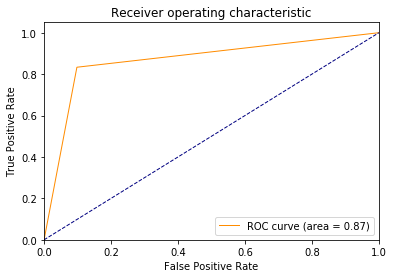

In [23]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_pred, y_val)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [24]:
threshold = 2.0

y_pred_test = rfc_best_model.predict(rescaledX_test)
predicted = (y_pred_test >= threshold).astype('bool')

accuracy = accuracy_score(y_test, predicted)
print(accuracy)

0.5434782608695652


In [25]:
# Create logistic regression
logistic = LogisticRegression(solver='liblinear')

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)

# Fit grid search
log_grid_result = clf.fit(rescaledX_train, y_train)

# View best hyperparameters
print("Best:", log_grid_result.best_params_)

# View best estimator
print("Best:", log_grid_result.best_estimator_)


Best: {'C': 21.544346900318832, 'penalty': 'l1'}
Best: LogisticRegression(C=21.544346900318832, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [26]:
logistic = LogisticRegression(solver='liblinear', C=21.544346900318832, penalty='l1')
logistic.fit(rescaledX_train, y_train)
y_pred_val= logistic.predict(rescaledX_val)

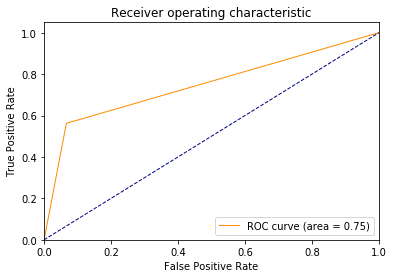

In [27]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_pred_val, y_val)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [28]:
#  Find threshold
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr+(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]
print(list(roc_t['threshold']))

[2.0]


In [29]:
threshold = 2.0

predicted_proba = logistic.predict_proba(rescaledX_test)
predicted = (predicted_proba [:,1] >= threshold).astype('bool')

accuracy = accuracy_score(y_test, predicted)
print(accuracy)

0.5434782608695652


In [30]:
print(logistic.coef_.shape)
print("Model coefficients: ", logistic.intercept_, logistic.coef_)
print("Score", logistic.score(rescaledX_train, y_train))


(1, 11)
Model coefficients:  [1.02804295] [[-1.12816727  0.         -8.83243833  4.33812348  1.07569594  4.20063583
   3.61203397  0.24286802  7.66126592  0.06988317 35.12067433]]
Score 0.8684807256235828


In [31]:
#instantiate LogReg with the best parameters
logistic = LogisticRegression(solver='liblinear', C=21.544346900318832, penalty='l1')
#fit the test data
logistic.fit(rescaledX_train, y_train)
#predict
y_pred_val = logistic.predict(rescaledX_test)

print("Logistic regression")
roc_logreg = cross_val_score(logreg, rescaledX_test, y_test, scoring='roc_auc', cv = 5).mean()
f1_logreg = cross_val_score(logreg, rescaledX_test, y_test, scoring='f1', cv = 5).mean()
precision_logreg = cross_val_score(logreg, rescaledX_test, y_test, scoring='precision', cv = 5).mean()
rec_logreg = cross_val_score(logreg, rescaledX_test, y_test, scoring='recall', cv = 5).mean()
print("AUC of Logistic Regression is: " , roc_logreg)
print("F1: " , f1_logreg)
print("Precission: " , precision_logreg)
print("Recall: " , rec_logreg)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_val))

Logistic regression
AUC of Logistic Regression is:  0.9431623931623931
F1:  0.8916011396011397
Precission:  0.8695238095238095
Recall:  0.9217948717948719
Accuracy: 0.6304347826086957
